# Approximating the Hessian for large neural networks

> port of https://github.com/google/spectral-density/blob/master/tf2/Lanczos_example.ipynb to JAX

This notebook describes how to use the spectral-density package with JAX. The main entry point of this package is the lanczos.lanczos_alg function, compatible with Jax models. This function takes the following arguments:

- ...

## Example 1: Full rank estimation for linear model

We start with a simplistic usecase: we wish to train the following linear model: 
$$
\arg\max_\beta \sum_i (y_i - \beta^Tx_i)^2
$$

As this optimization problem is quadratic, the Hessian of the loss is independent of $\beta$ and is equal to $2X^TX$. 
Let's verify this using lanczos.lanczos_alg, and setting the order of the approximation to the number of features, thus recovering the exact Hessian.

We first generate some random inputs and outputs:

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import jax.tree_util as tree_util
from jax import grad, jit, vmap
from flax import linen as nn
import optax
from matplotlib import pyplot as plt
import seaborn as sns

import hessian_computation
import lanczos

Generate random inputs and outputs

In [2]:
num_samples = 50
num_features = 16
key = random.PRNGKey(0)
X = random.normal(key, (num_samples, num_features))
y = random.normal(key, (num_samples,))

Then define a linear model with Flax linen

In [3]:
# Define a linear model using Flax
class LinearModel(nn.Module):
    num_features: int

    def setup(self):
        self.dense = nn.Dense(features=1, use_bias=False)

    def __call__(self, x):
        return self.dense(x)


# Initialise the model with params
model = LinearModel(num_features=num_features)
params = model.init(key, X)['params']

Define a loss function that takes as input the model and a batch of examples, and return a scalar loss. Here, we simply compute the mean squared error between the predictions of the model and the desired output.

In [4]:
def loss_fn(params, batch):
    x, y = batch
    preds = model.apply({'params': params}, x)
    return jnp.mean((y - preds) ** 2) # MSE loss

Optimizer (slightly arbitrary?)

In [5]:
# optimizer = optax.adam(learning_rate=0.001)
# opt_state = optimizer.init(params)

Compute full hessian

In [5]:
hessian_matrix = hessian_computation.full_hessian(lambda p: loss_fn(p, (X, y)), params)

Next, define a hessian vector product wrapper for the Lanczos algorithm to use

In [6]:
def hvp_fn(v):
    # Restructure v to match params tree structure
    v_restructured = tree_util.tree_map(
        lambda p: v.reshape(p.shape),
        params
    )
    # Compute HVP
    hvp_result = hessian_computation.hvp(
        lambda p, b: loss_fn(p, b),
        params,
        (X, y),
        v_restructured
    )
    # Flatten the result back to a vector
    hvp_flat, _ = tree_util.tree_flatten(hvp_result)
    return jnp.concatenate([x.ravel() for x in hvp_flat])


Fnally, we call `lanczos_alg`, setting order to the number of parameters to compute the *exact* Hessian. This function returns two tensors of shapes `(num_parameters, order)` and `(order, order)`, such that :
$$
H\approx VTV^T
$$
with an equality if `order = num_parameters`.

In [7]:
order = num_features
tridiag, vecs = lanczos.lanczos_alg(hvp_fn, num_features, order, key)

Reconstruct the Hessian

In [8]:
reconstructed_H = vecs.T @ tridiag @ vecs

twoxtx = 2 * X.T @ X

Plot the Hessians

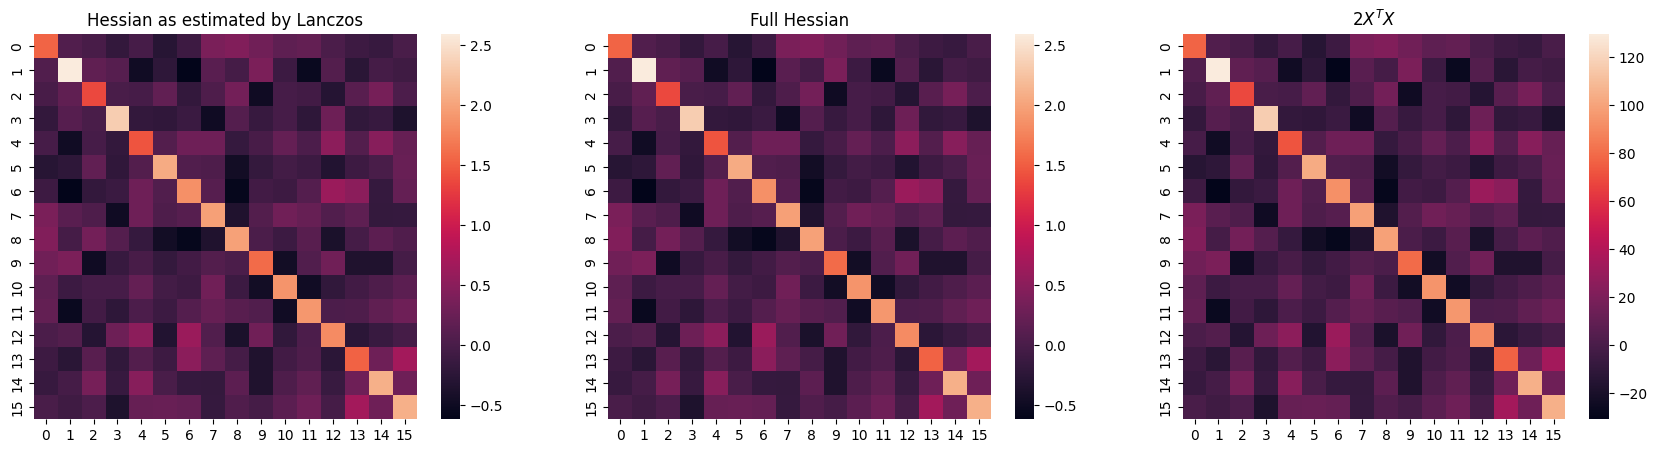

In [9]:
plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1)
plt.title("Hessian as estimated by Lanczos")
sns.heatmap(reconstructed_H)

plt.subplot(1, 3, 2)
plt.title("Full Hessian")
sns.heatmap(hessian_matrix)

plt.subplot(1, 3, 3)
plt.title("$2X^TX$")
sns.heatmap(twoxtx)

plt.show()

## More involved example - ConvNet on CIFAR-10.

Define a VGG16-like model (15.2M parameters) then train it for a little bit on CIFAR-10

In [10]:
from tensorflow_datasets.core.utils import disable_progress_bar
import tensorflow_datasets as tfds

from flax.training import train_state

In [11]:
def preprocess_images(data):
    image = data['image'].astype(jnp.float32) / 255.0
    label = data['label']
    return image, label

# # Load datasets
# def get_datasets():
#     # Load data using tfds but convert to numpy arrays
#     ds_train = tfds.load("cifar10", split="train")
#     ds_test = tfds.load("cifar10", split="test")

#     # Convert to numpy arrays
#     train_images = jnp.array([d['image'] for d in ds_train])
#     train_labels = jnp.array([d['label'] for d in ds_train])
#     test_images = jnp.array([d['image'] for d in ds_test])
#     test_labels = jnp.array([d['label'] for d in ds_test])

#     # Preprocess
#     train_images = train_images.astype(jnp.float32) / 255.0
#     test_images = test_images.astype(jnp.float32) / 255.0

#     return (train_images, train_labels), (test_images, test_labels)


# (train_loader, test_loader), info = tfds.load(
#     "mnist", split=["train", "test"], as_supervised=True, with_info=True
# )

# min_max_rgb = lambda image, label: (tf.cast(image, tf.float32) / 255., label)
# train_loader = train_loader.map(min_max_rgb)
# test_loader = test_loader.map(min_max_rgb)

# NUM_CLASSES = info.features["label"].num_classes
# IMG_SIZE = info.features["image"].shape

# train_loader_batched = train_loader.shuffle(
#     buffer_size=10_000, reshuffle_each_iteration=True
# ).batch(BATCH_SIZE, drop_remainder=True)

# test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)

# def get_datasets():
#     with disable_progress_bar():
#         (train_images, train_labels), (test_images, test_labels) = tfds.load(
#             "mnist",
#             split=["train", "test"],
#             as_supervised=True,
#             with_info=False,
#         )
#     return (train_images, train_labels), (test_images, test_labels)



import tensorflow as tf

(train_loader, test_loader), info = tfds.load(
    "cifar10", split=["train", "test"], as_supervised=True, with_info=True
)

min_max_rgb = lambda image, label: (tf.cast(image, tf.float32) / 255., label)

train_loader = train_loader.map(min_max_rgb)
test_loader = test_loader.map(min_max_rgb)

NUM_CLASSES = info.features["label"].num_classes
IMG_SIZE = info.features["image"].shape
BATCH_SIZE = 32

train_loader_batched = train_loader.shuffle(
    buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)


In [12]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x, training=True):
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=128, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.Conv(features=128, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x


In [13]:
def create_train_state(rng, learning_rate, momentum):
    """Creates initial `TrainState`."""
    cnn = CNN()
    params = cnn.init(rng, jnp.ones([1, 32, 32, 3]))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn=cnn.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    def loss_fn(params):
        images, labels = batch
        logits = state.apply_fn({'params': params}, images)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=labels).mean()
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [14]:
def train_epoch(state, train_ds, batch_size, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds[0])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []

    for perm in perms:
        batch_images = train_ds[0][perm, ...]
        batch_labels = train_ds[1][perm, ...]
        state, loss = train_step(state, (batch_images, batch_labels))
        epoch_loss.append(loss)

    train_loss = jnp.mean(jnp.array(epoch_loss))
    return state, train_loss

In [15]:
# train_ds, test_ds = get_datasets()
rng = jax.random.PRNGKey(42)

batch_size = 32
num_epochs = 1

state = create_train_state(rng, learning_rate=0.001, momentum=0.9)
for epoch in range(num_epochs):
    rng, subrng = jax.random.split(rng)
    state, train_loss = train_epoch(state, train_ds, batch_size, subrng)
    print(f"Epoch {epoch}, Loss: {train_loss}")

NameError: name 'train_ds' is not defined

In [83]:
def loss_fn(params, batch):
    """Loss function for Hessian computation"""
    images, labels = batch
    logits = model.apply({'params': params}, images)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=labels).mean()
    return loss

batches_list = [next(iter(train_ds)) for i in range(10)]
NUM_CLASSES = 10
def batches_fn():
  for b in batches_list:
    # yield b
    # yield as jax array, not eagertensor
    targets = jax.nn.one_hot(jnp.array(b[1]), NUM_CLASSES)
    yield (jnp.array(b[0]), targets)
    # yield (jnp.array(b[0]), jnp.array(b[1]))

# Modified density plotting function
def plot_density(grids, density, label=None):
    plt.semilogy(grids, density, label=label)
    plt.ylim(1e-10, 1e2)
    plt.ylabel("Density")
    plt.xlabel("Eigenvalue")
    plt.legend()


In [88]:
# test dataloader
batches = batches_fn()
sample_batch = next(batches)
print(sample_batch[0].shape, sample_batch[1].shape)

(32, 32, 3) (32, 32, 3, 10)


In [84]:
# def hvp_fn(params, batch):
#     def _hvp_fn(v):
#         return hessian_computation.hvp(
#             lambda p, b: loss_fn(p, b),
#             params,
#             batch,
#             v
#         )

#     return _hvp_fn

hvp, unravel, num_params = hessian_computation.get_hvp_fn(loss_fn, params, batches_fn)
hvp_cl = lambda v: hvp(params, v) / len(batches_list) # Match the API required by lanczos_alg

In [85]:
# Get total number of parameters
flat_params, _ = tree_util.tree_flatten(params)
total_params = sum(p.size for p in flat_params)

In [86]:
order = min(90, total_params)  # Use minimum of 90 or total params
key = jax.random.PRNGKey(1)

# Create a batch for Hessian computation
# batch = next(iter(cifar_dataset_train.batch(128)))
# batch = (train_ds[0][:128], train_ds[1][:128])
# hvp = hvp_fn(params, batch)

tridiag, vecs = lanczos.lanczos_alg(hvp_cl, total_params, order, key)


ScopeParamShapeError: Initializer expected to generate shape (16, 1) but got shape (3, 1) instead for parameter "kernel" in "/dense". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)